In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
import math
from WholeBrain.Utils.p_values import plotComparisonAcrossLabels2

In [2]:
from BrainTumor.subjects import Subjects
from BrainTumor.ignition_utils import *

data_dir = "../../data"

subjects = Subjects()
subjects.initialize(data_dir)

control_subset = subjects.get_control_subset()
tumor_subset = subjects.get_tumor_subset()

print("************************* Subjects Info *************************")
subjects.pretty_print()
print("*****************************************************************")

************************* Subjects Info *************************
ID              FMRI_TR (ms)    TYPE                           VOLUME (cm³)    # REGIONS WITH TUMOR
sub-CON01       2100.0          none                           0.0             0              
sub-CON02       2100.0          none                           0.0             0              
sub-CON03       2100.0          none                           0.0             0              
sub-CON04       2100.0          none                           0.0             0              
sub-CON05       2400.0          none                           0.0             0              
sub-CON06       2400.0          none                           0.0             0              
sub-CON07       2400.0          none                           0.0             0              
sub-CON08       2400.0          none                           0.0             0              
sub-CON09       2400.0          none                           0.0        

Mean FC for control subjects

In [3]:
compound_control_fc = np.dstack([sub.preop_data.fc_dk68 for _, sub in control_subset.items()])
mean_control_fc = np.mean(compound_control_fc, axis=2)
std_control_fc = np.std(compound_control_fc, axis=2)

Plot the minimum std and the maximum std for the compounded control fc

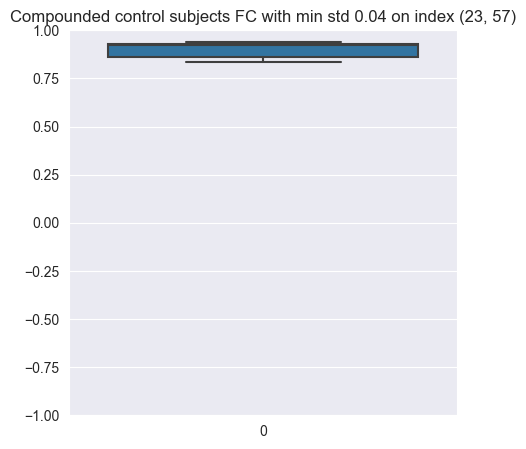

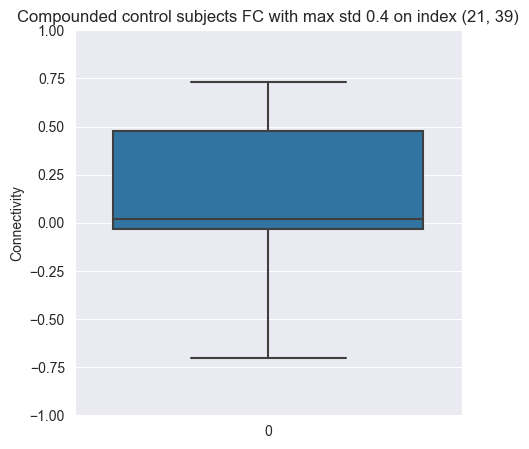

In [4]:
if True:
    aux = np.copy(std_control_fc)
    np.fill_diagonal(aux, np.Inf)
    (min_i, min_j) = np.unravel_index(np.argmin(aux), std_control_fc.shape)
    (max_i, max_j) = np.unravel_index(np.argmax(std_control_fc), std_control_fc.shape)

    plt.figure(figsize=(5, 5))
    plt.ylim(-1.0, 1.0)
    sns.boxplot(data=compound_control_fc[min_i][min_j])
    plt.title(
        "Compounded control subjects FC with min std "
        + str(round(std_control_fc[min_i][min_j], 2))
        + " on index ("+str(min_i)+", "+str(min_j)+")")
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.ylim(-1.0, 1.0)
    g2 = sns.boxplot(data=compound_control_fc[max_i][max_j])
    plt.ylabel("Connectivity")
    plt.title(
        "Compounded control subjects FC with max std "
        + str(round(std_control_fc[max_i][max_j], 2))
        + " on index ("+str(max_i)+", "+str(max_j)+")")
    plt.show()

Display mean control fc heatmap


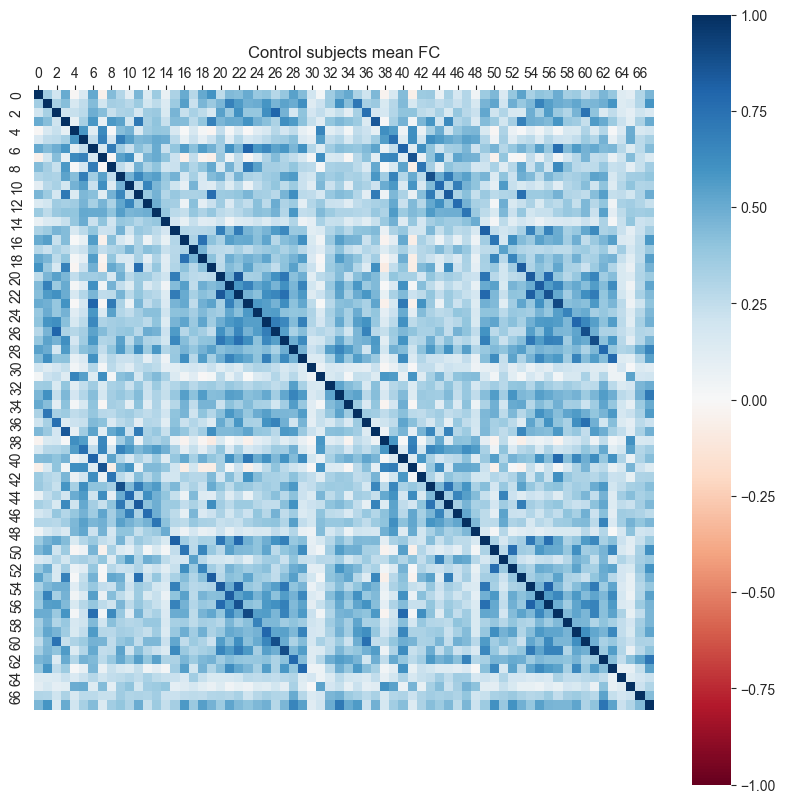

In [5]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(mean_control_fc, cmap="RdBu", square=True, vmin=-1.0, vmax=1.0)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.title("Control subjects mean FC")
plt.show()

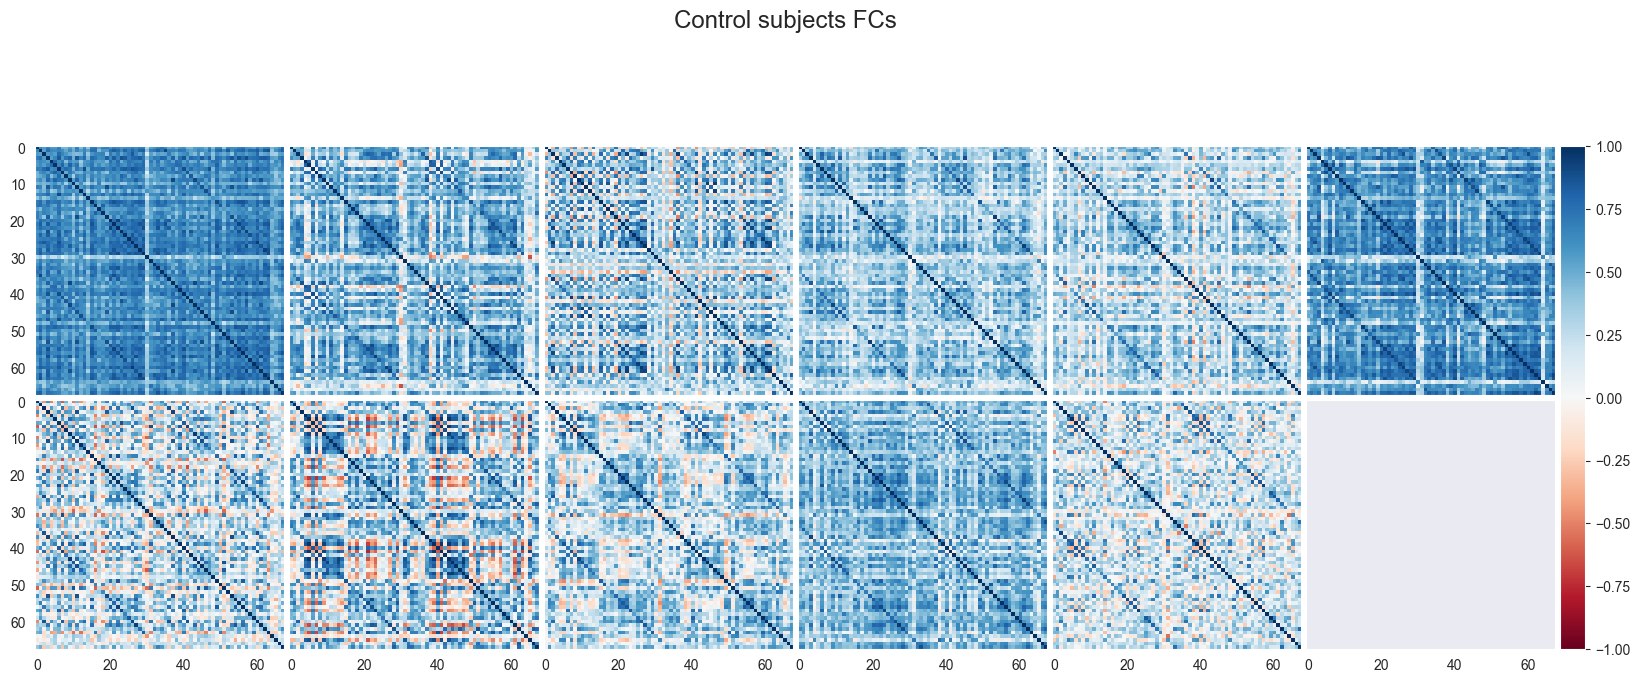

In [6]:
if True:
    fcs = [sub.preop_data.fc_dk68 for k, sub in control_subset.items()]
    fig = plt.figure(figsize=(20, 8))

    grid = AxesGrid(
        fig,
        111,
        nrows_ncols=(2, math.ceil(control_subset.count()/2)),
        axes_pad=0.05,
        share_all=True,
        label_mode="L",
        cbar_location="right",
        cbar_mode="single"
    )

    for val, ax in zip(fcs, grid):
        im = ax.imshow(val, vmin=-1.0, vmax=1.0, cmap="RdBu")
        # ax.heatmap(val, vmin=-1.0, vmax=1.0)

    grid.cbar_axes[0].colorbar(im)
    grid.axes_all

    for cax in grid.axes_all:
        cax.grid(False)

    # plt.suptitle("Control subjects FCs")
    fig.suptitle("Control subjects FCs", fontsize='xx-large')
    plt.show()


Note: FC's has a positive tendency... Some control subjects they don't nearly have negative correlations(?)

Similar as in ignition, we will watch what happens on delta FC connections compared to the control subjects mean FC between three bins, tumor<->tumor, tumor<->non-tumor and non-tumor<->non-tumor.

In [7]:
t_t_bin = []
t_n_bin = []
n_n_bin = []

for k, sub in tumor_subset.items():
    # For each region connection (excluding self and repeated)
    for i in range(68):
        for j in range(i):
            delta = sub.preop_data.fc_dk68[i][j] - mean_control_fc[i][j]
            # Three bins
            if sub.tumor_regions.is_tumor_region_by_id(i) and sub.tumor_regions.is_tumor_region_by_id(j):
                t_t_bin.append((k, i, j, delta))
            elif (not sub.tumor_regions.is_tumor_region_by_id(i) and sub.tumor_regions.is_tumor_region_by_id(j)) or \
                (sub.tumor_regions.is_tumor_region_by_id(i) and not sub.tumor_regions.is_tumor_region_by_id(j)):
                t_n_bin.append((k, i, j, delta))
            elif not sub.tumor_regions.is_tumor_region_by_id(i) and not sub.tumor_regions.is_tumor_region_by_id(j):
                n_n_bin.append((k, i, j, delta))

Let's visualize the three bins and compare them.

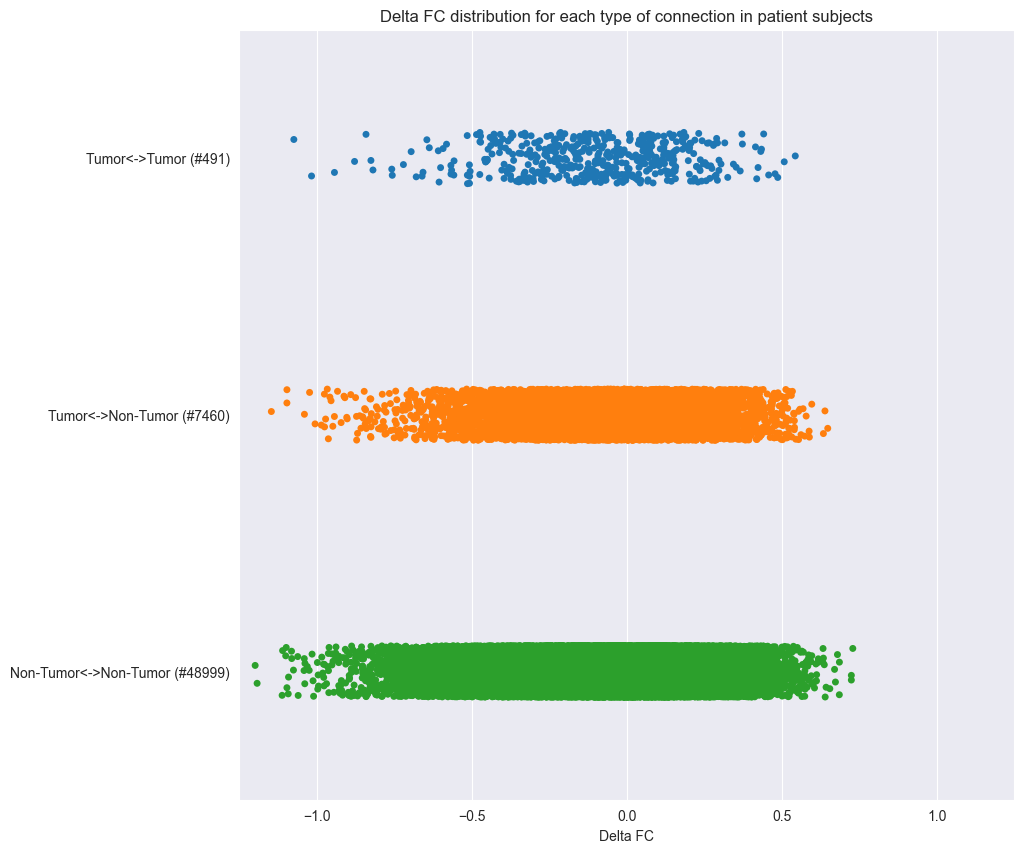

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor<->Tumor 
(#491) vs. Tumor<->Non-Tumor 
(#7460): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.404e-03 U_stat=1.682e+06
Tumor<->Non-Tumor 
(#7460) vs. Non-Tumor<->Non-Tumor 
(#48999): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.508e-06 U_stat=1.767e+08
Tumor<->Tumor 
(#491) vs. Non-Tumor<->Non-Tumor 
(#48999): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.893e-06 U_stat=1.062e+07


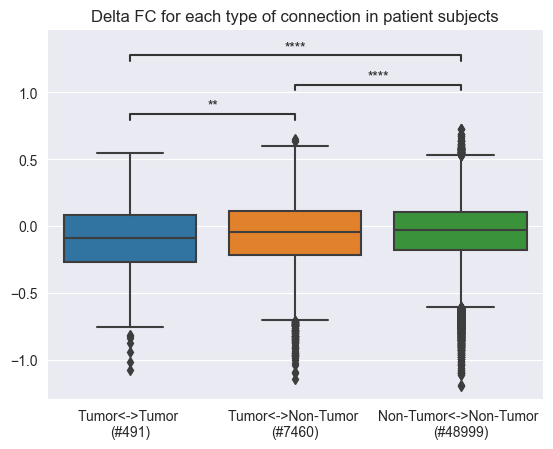

In [8]:
if True:
    t_t = [b[3] for b in t_t_bin]
    t_n = [b[3] for b in t_n_bin]
    n_n = [b[3] for b in n_n_bin]

    plt.figure(figsize=(10, 10))
    g = sns.stripplot(
        data={
            'Tumor<->Tumor (#'+str(len(t_t))+')': t_t,
            'Tumor<->Non-Tumor (#'+str(len(t_n))+')': t_n,
            'Non-Tumor<->Non-Tumor (#'+str(len(n_n))+')': n_n
        },
        orient='h',

    )
    g.set_xlim([-1.25, 1.25])
    plt.xlabel("Delta FC")
    plt.title("Delta FC distribution for each type of connection in patient subjects")
    plt.show()

    plotComparisonAcrossLabels2(
        {
            'Tumor<->Tumor \n(#'+str(len(t_t))+')': t_t,
            'Tumor<->Non-Tumor \n(#'+str(len(t_n))+')': t_n,
            'Non-Tumor<->Non-Tumor \n(#'+str(len(n_n))+')': n_n
        },
        graphLabel="Delta FC for each type of connection in patient subjects"
    )

## TODO: Maybe for a fair comparision, we need to pick randomly from Non-Tumor<->Non-Tumor so we have roughly the same number of connections?